In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
DATASET_ROOT = r"C:\Users\ASUS\OneDrive\Desktop\fish_clasification\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

print("Train classes:", os.listdir(TRAIN_DIR))

Train classes: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

num_classes = len(os.listdir(TRAIN_DIR))
print("Number of classes:", num_classes)

Number of classes: 11


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [5]:
class_indices = train_gen.class_indices
inv_classes = {v:k for k,v in class_indices.items()}

with open("class_names.json", "w") as f:
    json.dump(inv_classes, f)

print(inv_classes)

{0: 'animal fish', 1: 'animal fish bass', 2: 'fish sea_food black_sea_sprat', 3: 'fish sea_food gilt_head_bream', 4: 'fish sea_food hourse_mackerel', 5: 'fish sea_food red_mullet', 6: 'fish sea_food red_sea_bream', 7: 'fish sea_food sea_bass', 8: 'fish sea_food shrimp', 9: 'fish sea_food striped_red_mullet', 10: 'fish sea_food trout'}


In [6]:
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE+(3,)),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn()
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,499 (84.87 MB)

 Trainable params: 22,247,499 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
cnn_ckpt = ModelCheckpoint(
    "cnn_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[cnn_ckpt, EarlyStopping(patience=3)]
)

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.3399 - loss: 1.9408
Epoch 1: val_accuracy improved from None to 0.77930, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 279s 710ms/step - accuracy: 0.4529 - loss: 1.5723 - val_accuracy: 0.7793 - val_loss: 0.7457
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6732 - loss: 0.9456
Epoch 2: val_accuracy improved from 0.77930 to 0.80678, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 177s 454ms/step - accuracy: 0.6779 - loss: 0.9279 - val_accuracy: 0.8068 - val_loss: 0.5940
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7432 - loss: 0.7280
Epoch 3: val_accuracy improved from 0.80678 to 0.84615, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 180s 460ms/step - accuracy: 0.7578 - loss: 0.6963 - val_accuracy: 0.8462 - val_loss: 0.5221
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7912 - loss: 0.6117
Epoch 4: val_accuracy improved from 0.84615 to 0.88919, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 177s 452ms/step - accuracy: 0.7942 - loss: 0.6035 - val_accuracy: 0.8892 - val_loss: 0.3359
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8272 - loss: 0.5190
Epoch 5: val_accuracy improved from 0.88919 to 0.89927, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 215s 550ms/step - accuracy: 0.8418 - loss: 0.4785 - val_accuracy: 0.8993 - val_loss: 0.2979
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8422 - loss: 0.4331
Epoch 6: val_accuracy improved from 0.89927 to 0.92491, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 175s 449ms/step - accuracy: 0.8569 - loss: 0.4154 - val_accuracy: 0.9249 - val_loss: 0.2508
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8889 - loss: 0.3301
Epoch 7: val_accuracy improved from 0.92491 to 0.95147, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 176s 450ms/step - accuracy: 0.8765 - loss: 0.3622 - val_accuracy: 0.9515 - val_loss: 0.1695
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8959 - loss: 0.2934
Epoch 8: val_accuracy did not improve from 0.95147
390/390 ━━━━━━━━━━━━━━━━━━━━ 173s 444ms/step - accuracy: 0.8940 - loss: 0.3033 - val_accuracy: 0.9295 - val_loss: 0.2117
Epoch 9/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9063 - loss: 0.2932
Epoch 9: val_accuracy improved from 0.95147 to 0.96062, saving model to cnn_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 175s 448ms/step - accuracy: 0.8956 - loss: 0.3207 - val_accuracy: 0.9606 - val_loss: 0.1843
Epoch 10/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9076 - loss: 0.2851
Epoch 10: val_accuracy did not improve from 0.96062
390/390 ━━━━━━━━━━━━━━━━━━━━ 176s 451ms/step - accuracy: 0.9065 - loss: 0.2771 - val_accuracy: 0.9194 - val_loss: 0.2379


In [8]:
def build_transfer(base_model):
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
models_dict = {
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,)),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
}

best_acc = 0
best_model_name = ""
best_model_path = ""

for name, base in models_dict.items():
    print(f"\nTraining {name}")
    model = build_transfer(base)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    ckpt = ModelCheckpoint(
        f"{name}_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[ckpt]
    )

    acc = max(history.history["val_accuracy"])
    if acc > best_acc:
        best_acc = acc
        best_model_name = name
        best_model_path = f"{name}_best.h5"

print(" Best Model:", best_model_name, "Accuracy:", best_acc)


Training MobileNetV2
Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.7137 - loss: 0.8920
Epoch 1: val_accuracy improved from None to 0.97070, saving model to MobileNetV2_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 222s 558ms/step - accuracy: 0.8467 - loss: 0.4798 - val_accuracy: 0.9707 - val_loss: 0.0957
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9381 - loss: 0.1800
Epoch 2: val_accuracy did not improve from 0.97070
390/390 ━━━━━━━━━━━━━━━━━━━━ 190s 488ms/step - accuracy: 0.9417 - loss: 0.1674 - val_accuracy: 0.9652 - val_loss: 0.1019
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9569 - loss: 0.1167
Epoch 3: val_accuracy improved from 0.97070 to 0.97985, saving model to MobileNetV2_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 143s 367ms/step - accuracy: 0.9589 - loss: 0.1132 - val_accuracy: 0.9799 - val_loss: 0.0830
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9659 - loss: 0.1045
Epoch 4: val_accuracy improved from 0.97985 to 0.98352, saving model to MobileNetV2_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 140s 359ms/step - accuracy: 0.9674 - loss: 0.0987 - val_accuracy: 0.9835 - val_loss: 0.0417
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9650 - loss: 0.0968
Epoch 5: val_accuracy did not improve from 0.98352
390/390 ━━━━━━━━━━━━━━━━━━━━ 139s 357ms/step - accuracy: 0.9671 - loss: 0.0931 - val_accuracy: 0.9826 - val_loss: 0.0426

Training VGG16
Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3663 - loss: 1.8722
Epoch 1: val_accuracy improved from None to 0.74267, saving model to VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.5028 - loss: 1.5081 - val_accuracy: 0.7427 - val_loss: 0.9159
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7138 - loss: 0.9112
Epoch 2: val_accuracy improved from 0.74267 to 0.84982, saving model to VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 22144s 57s/step - accuracy: 0.7415 - loss: 0.8270 - val_accuracy: 0.8498 - val_loss: 0.5780
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7878 - loss: 0.6552
Epoch 3: val_accuracy improved from 0.84982 to 0.88553, saving model to VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 910s 2s/step - accuracy: 0.8076 - loss: 0.6032 - val_accuracy: 0.8855 - val_loss: 0.4177
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8343 - loss: 0.5149
Epoch 4: val_accuracy improved from 0.88553 to 0.90018, saving model to VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.8495 - loss: 0.4784 - val_accuracy: 0.9002 - val_loss: 0.3490
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8726 - loss: 0.4134
Epoch 5: val_accuracy improved from 0.90018 to 0.92857, saving model to VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8700 - loss: 0.4141 - val_accuracy: 0.9286 - val_loss: 0.2600

Training ResNet50
Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.1515 - loss: 2.3982
Epoch 1: val_accuracy improved from None to 0.15751, saving model to ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 401s 995ms/step - accuracy: 0.1680 - loss: 2.3277 - val_accuracy: 0.1575 - val_loss: 2.2599
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1724 - loss: 2.2463
Epoch 2: val_accuracy improved from 0.15751 to 0.18132, saving model to ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.1793 - loss: 2.2308 - val_accuracy: 0.1813 - val_loss: 2.1641
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.1913 - loss: 2.1865
Epoch 3: val_accuracy improved from 0.18132 to 0.18681, saving model to ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.1920 - loss: 2.1834 - val_accuracy: 0.1868 - val_loss: 2.1314
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1891 - loss: 2.1634
Epoch 4: val_accuracy improved from 0.18681 to 0.20604, saving model to ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 846s 2s/step - accuracy: 0.1915 - loss: 2.1558 - val_accuracy: 0.2060 - val_loss: 2.0760
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2015 - loss: 2.1344
Epoch 5: val_accuracy improved from 0.20604 to 0.21886, saving model to ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 2354s 6s/step - accuracy: 0.2014 - loss: 2.1256 - val_accuracy: 0.2189 - val_loss: 2.0587

Training InceptionV3
Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6102 - loss: 1.2713
Epoch 1: val_accuracy improved from None to 0.92491, saving model to InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 167s 402ms/step - accuracy: 0.7462 - loss: 0.7818 - val_accuracy: 0.9249 - val_loss: 0.2468
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8732 - loss: 0.3772
Epoch 2: val_accuracy improved from 0.92491 to 0.94963, saving model to InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 153s 392ms/step - accuracy: 0.8794 - loss: 0.3660 - val_accuracy: 0.9496 - val_loss: 0.1503
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8811 - loss: 0.3439
Epoch 3: val_accuracy improved from 0.94963 to 0.95971, saving model to InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 156s 401ms/step - accuracy: 0.8916 - loss: 0.3113 - val_accuracy: 0.9597 - val_loss: 0.1266
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9124 - loss: 0.2613
Epoch 4: val_accuracy did not improve from 0.95971
390/390 ━━━━━━━━━━━━━━━━━━━━ 159s 406ms/step - accuracy: 0.9133 - loss: 0.2524 - val_accuracy: 0.9560 - val_loss: 0.1191
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9162 - loss: 0.2378
Epoch 5: val_accuracy improved from 0.95971 to 0.96520, saving model to InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 156s 398ms/step - accuracy: 0.9216 - loss: 0.2281 - val_accuracy: 0.9652 - val_loss: 0.1093

Training EfficientNetB0
Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1470 - loss: 2.3662
Epoch 1: val_accuracy improved from None to 0.17125, saving model to EfficientNetB0_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 164s 388ms/step - accuracy: 0.1569 - loss: 2.3397 - val_accuracy: 0.1712 - val_loss: 2.3191
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1812 - loss: 2.3183
Epoch 2: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 146s 375ms/step - accuracy: 0.1761 - loss: 2.3172 - val_accuracy: 0.1712 - val_loss: 2.3159
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.1834 - loss: 2.3082
Epoch 3: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 145s 372ms/step - accuracy: 0.1757 - loss: 2.3113 - val_accuracy: 0.1712 - val_loss: 2.3120
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1751 - loss: 2.3073
Epoch 4: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 145s 371ms/step - accuracy: 0.1761 - loss: 2.3074 - val_accuracy: 0.1712 - val_loss: 2.3112
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.1786 - loss: 2.3060
Epoch 5: val_ac

In [10]:
best_model = tf.keras.models.load_model(best_model_path)

test_loss, test_acc = best_model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 344ms/step - accuracy: 0.9925 - loss: 0.0237
Test Accuracy: 0.9924694299697876


200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step


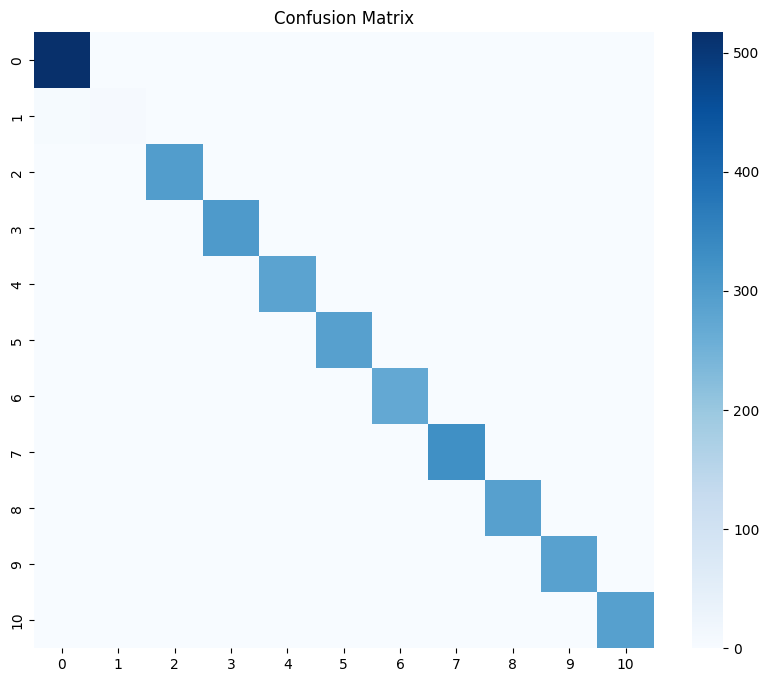

                                  precision    recall  f1-score   support

                     animal fish       0.99      0.99      0.99       520
                animal fish bass       1.00      0.54      0.70        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       1.00      0.99      1.00       286
        fish sea_food red_mullet       0.99      0.99      0.99       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       0.99      1.00      1.00       289
fish sea_food striped_red_mullet       0.98      0.98      0.98       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           0.99      3187
                       macro avg    

In [11]:
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(
    y_true, y_pred, target_names=list(inv_classes.values())
))

In [12]:
best_model.save("final_fish_classifier.h5")
print("Final model saved")

Final model saved
